# Creating Dataset Class

The dataset class is a subclass of `torch.utils.data.Dataset`.  
We will create two `CaptchaDetectionDataset` instances in the next cells:  
- One will combine `field` and `draw1`.  
- The other will combine `field` and `draw2`.  

Afterward, we will concatenate these datasets and shuffle them during training to improve model generalization.  

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms
from torch.utils.data import ConcatDataset, DataLoader

class CaptchaDetectionDataset(Dataset):
    def __init__(self, field_folder, draw_folder, label_csv, 
                 transform_field=None, transform_draw=None, transform_label=None):
        """
        Args:
            field_folder (str): Path to the folder containing field images (210x210).
            draw_folder (str): Path to the folder containing draw images (50x50).
            label_csv (str): Path to the CSV file containing labels with columns:
                             "img_name", "x", "y".
            transform_field (callable, optional): Transform to apply to field images.
            transform_draw (callable, optional): Transform to apply to draw images.
            transform_label (callable, optional): Transform to apply to labels.
        """
        self.field_folder = field_folder
        self.draw_folder = draw_folder
        self.labels_df = pd.read_csv(label_csv)
        
        # Optional transforms for images/labels
        self.transform_field = transform_field
        self.transform_draw = transform_draw
        self.transform_label = transform_label
        
        # Create a list of image names from the CSV
        self.img_names = self.labels_df["img_name"].tolist()
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        # Get the image file name from CSV
        img_name = self.img_names[idx]
        
        # Construct full paths for field and draw images
        field_img_path = os.path.join(self.field_folder, img_name)
        draw_img_path = os.path.join(self.draw_folder, img_name)
        
        # Load images using PIL and convert them to RGB
        field_img = Image.open(field_img_path).convert('RGB')
        draw_img = Image.open(draw_img_path).convert('RGB')
        
        # Apply transformations if provided (for example, resizing, normalization, converting to tensor)
        if self.transform_field:
            field_img = self.transform_field(field_img)
        if self.transform_draw:
            draw_img = self.transform_draw(draw_img)
        
        # Extract label (x, y) from the CSV row and convert to a float tensor
        row = self.labels_df.iloc[idx]
        x = float(row["x"])
        y = float(row["y"])
        label = torch.tensor([x, y], dtype=torch.float32)
        if self.transform_label:
            label = self.transform_label(label)
        
        return field_img, draw_img, label

# Example usage:
def create_train_dataset():
    # Define transforms: Convert images to tensors, resize if needed, etc.
    transform_field = transforms.Compose([
        transforms.Resize((210, 210)),
        transforms.ToTensor()  # Converts to tensor and scales pixel values to [0, 1]
    ])
    
    transform_draw = transforms.Compose([
        transforms.Resize((50, 50)),
        transforms.ToTensor()
    ])

    train_folder = "train_set/"
    # Folder paths
    field_folder = train_folder + "field"   # e.g., images of size 210x210
    draw_folder = train_folder + "rotated_draw1"       # e.g., images of size 50x50
    label_csv = train_folder + "rotated_draw1/augmented_labels.csv"          # CSV with columns: "img_name", "x", "y"
    
    # Create dataset
    dataset1 = CaptchaDetectionDataset(field_folder, draw_folder, label_csv,
                                    transform_field=transform_field,
                                    transform_draw=transform_draw)

    field_folder = train_folder + "field"    # e.g., images of size 210x210
    draw_folder = train_folder + "rotated_draw2"       # e.g., images of size 50x50
    label_csv = train_folder + "rotated_draw2/augmented_labels.csv"           # CSV with columns: "img_name", "x", "y"

    # Create dataset
    dataset2 = CaptchaDetectionDataset(field_folder, draw_folder, label_csv,
                                    transform_field=transform_field,
                                    transform_draw=transform_draw)


    dataset = ConcatDataset([dataset1, dataset2])
    return dataset

def create_test_dataset():
    # Define transforms: Convert images to tensors, resize if needed, etc.
    transform_field = transforms.Compose([
        transforms.Resize((210, 210)),
        transforms.ToTensor()  # Converts to tensor and scales pixel values to [0, 1]
    ])
    
    transform_draw = transforms.Compose([
        transforms.Resize((50, 50)),
        transforms.ToTensor()
    ])

    test_folder = "test_set/"
    # Folder paths
    field_folder = test_folder + "field"   # e.g., images of size 210x210
    draw_folder = test_folder + "rotated_draw1"       # e.g., images of size 50x50
    label_csv = test_folder + "rotated_draw1/augmented_labels.csv"          # CSV with columns: "img_name", "x", "y"
    
    # Create dataset
    dataset1 = CaptchaDetectionDataset(field_folder, draw_folder, label_csv,
                                    transform_field=transform_field,
                                    transform_draw=transform_draw)

    field_folder = test_folder + "field"    # e.g., images of size 210x210
    draw_folder = test_folder + "rotated_draw2"       # e.g., images of size 50x50
    label_csv = test_folder + "rotated_draw2/augmented_labels.csv"           # CSV with columns: "img_name", "x", "y"

    # Create dataset
    dataset2 = CaptchaDetectionDataset(field_folder, draw_folder, label_csv,
                                    transform_field=transform_field,
                                    transform_draw=transform_draw)


    dataset = ConcatDataset([dataset1, dataset2])
    return dataset


dataset = create_test_dataset()
# dataset = create_train_dataset()
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Iterate over one batch and print shapes
for field_img, draw_img, label in data_loader:
    print("Field image batch shape:", field_img.shape)  # Expected: (B, 3, 210, 210)
    print("Draw image batch shape:", draw_img.shape)    # Expected: (B, 3, 50, 50)
    print("Label batch shape:", label.shape)            # Expected: (B, 2)
    break


Field image batch shape: torch.Size([8, 3, 210, 210])
Draw image batch shape: torch.Size([8, 3, 50, 50])
Label batch shape: torch.Size([8, 2])


# Model Architecture: DrawLocatorNet

The `DrawLocatorNet` is a convolutional neural network designed to localize a specific draw (a small image) within a larger field image. The model takes two inputs:
- A **field image** of size 210x210 (3 channels).
- A **draw image** of size 50x50 (3 channels).

The model outputs normalized (x, y) coordinates (values between 0 and 1) that indicate the predicted location of the draw within the field.

---

## Architecture Overview

### 1. Field Branch
- **Input:** Field image of size 210x210.
- **Architecture:**  
  The field branch uses three convolutional blocks:
  - **Block 1:**  
    - Convolution with 32 filters, kernel size 3x3, with padding 1.  
    - Batch normalization, followed by ReLU activation.  
    - Max pooling to downsample the spatial resolution from 210x210 to 105x105.
  - **Block 2:**  
    - Convolution with 64 filters, kernel size 3x3, with padding 1.  
    - Batch normalization and ReLU activation.  
    - Max pooling reduces the feature map size to approximately 52x52.
  - **Block 3:**  
    - Convolution with 128 filters, kernel size 3x3, with padding 1.  
    - Batch normalization and ReLU activation.  
    - Max pooling further downsamples the features to 26x26.

- **Output:** A feature map of shape (B, 128, 26, 26), where B is the batch size.

### 2. Draw Branch
- **Input:** Draw image of size 50x50.
- **Architecture:**  
  The draw branch also consists of three convolutional blocks:
  - **Block 1:**  
    - Convolution with 32 filters, kernel size 3x3, with padding 1.  
    - Batch normalization, ReLU activation, and max pooling to downsample to 25x25.
  - **Block 2:**  
    - Convolution with 64 filters, kernel size 3x3, with padding 1.  
    - Batch normalization, ReLU activation, and max pooling to downsample to approximately 12x12.
  - **Block 3:**  
    - Convolution with 128 filters, kernel size 3x3, with padding 1.  
    - Batch normalization and ReLU activation.  
    - Adaptive average pooling compresses the feature map to a 1x1 size.

- **Output:** A feature vector of shape (B, 128) after flattening.

### 3. Correlation and Localization
- **Correlation Map:**  
  The model computes a correlation map by performing an element-wise multiplication between the field feature map and the broadcasted draw feature vector (reshaped to (B, 128, 1, 1)). This multiplication is summed across the channel dimension, resulting in a correlation map of shape (B, 26, 26).

- **Soft-Argmax:**  
  The correlation map is flattened and passed through a softmax to generate a probability distribution over the spatial locations. Using this distribution along with a generated coordinate grid, the expected x and y coordinates are computed via a soft-argmax operation.

- **Normalization:**  
  The predicted x and y coordinates (initially in the 26x26 feature grid) are normalized to the [0, 1] range by dividing by the width and height of the grid.

- **Final Output:**  
  The model outputs a tensor of shape (B, 2) containing the normalized (x, y) coordinates of the draw within the field image.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DrawLocatorNet(nn.Module):
    def __init__(self):
        super(DrawLocatorNet, self).__init__()
        # Field branch: for the field image (210x210)
        # We use three convolutional blocks.
        self.field_cnn = nn.Sequential(
            # Block 1: 210x210 -> 105x105
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B,32,210,210)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                           # (B,32,105,105)
            
            # Block 2: 105x105 -> 52x52 (approx.)
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (B,64,105,105)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                           # (B,64,52,52)
            
            # Block 3: 52x52 -> 26x26
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# (B,128,52,52)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)                            # (B,128,26,26)
        )
        
        # Draw branch: for the draw image (50x50)
        # We use three convolutional blocks and an adaptive average pooling to get a feature vector.
        self.draw_cnn = nn.Sequential(
            # Block 1: 50x50 -> 25x25
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # (B,32,50,50)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B,32,25,25)
            
            # Block 2: 25x25 -> 12x12 (approx.)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # (B,64,25,25)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # (B,64,12,12)
            
            # Block 3: 12x12 remains 12x12 but increases channels
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (B,128,12,12)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                    # (B,128,1,1)
        )
    
    def forward(self, field_img, draw_img):
        """
        Args:
            field_img: Tensor of shape (B,3,210,210)
            draw_img: Tensor of shape (B,3,50,50)
        Returns:
            preds: Tensor of shape (B,2) with the predicted (x, y) coordinates normalized in [0,1].
        """
        # Extract features from the field image; shape: (B,128,26,26)
        field_feat = self.field_cnn(field_img)
        
        # Extract feature vector from the draw image; shape: (B,128,1,1)
        draw_feat = self.draw_cnn(draw_img)
        draw_feat = draw_feat.view(draw_feat.size(0), -1)  # (B,128)
        
        # Compute the correlation map:
        # For each spatial location in the field feature map, compute the dot product with the draw feature vector.
        # Result: (B,26,26)
        correlation = (field_feat * draw_feat.view(draw_feat.size(0), draw_feat.size(1), 1, 1)).sum(dim=1)
        
        # Get spatial dimensions (H, W) of the correlation map
        B, H, W = correlation.size()
        
        # Create a coordinate grid corresponding to the correlation map.
        device = correlation.device
        grid_y, grid_x = torch.meshgrid(torch.arange(H, device=device), torch.arange(W, device=device), indexing='ij')
        grid_x = grid_x.float()
        grid_y = grid_y.float()
        
        # Flatten the correlation map and compute softmax to obtain a probability distribution over spatial locations.
        correlation_flat = correlation.view(B, -1)  # shape: (B, H*W)
        prob = F.softmax(correlation_flat, dim=1).view(B, H, W)  # shape: (B, H, W)
        
        # Compute the expected coordinates (soft-argmax) in the feature map grid.
        pred_x = (prob * grid_x).view(B, -1).sum(dim=1)
        pred_y = (prob * grid_y).view(B, -1).sum(dim=1)
        
        # The predicted coordinates are in the feature map scale (26x26).
        # To normalize them to [0,1], we simply divide by the width/height of the feature map.
        pred_x = pred_x / W
        pred_y = pred_y / H
        
        preds = torch.stack([pred_x, pred_y], dim=1)  # shape: (B,2)
        return preds

# Example usage:
if __name__ == '__main__':
    model = DrawLocatorNet()
    # Create dummy inputs
    field_img = torch.randn(4, 3, 210, 210)   # Batch of 4 field images
    draw_img = torch.randn(4, 3, 50, 50)        # Batch of 4 draw images
    
    
    preds = model(field_img, draw_img)
    print("Predicted coordinates:", preds)


Predicted coordinates: tensor([[0.1644, 0.5042],
        [0.5386, 0.2069],
        [0.2815, 0.3728],
        [0.5640, 0.0538]], grad_fn=<StackBackward0>)


# Training Pipeline for DrawLocatorNet

This section of the code defines the training pipeline for the `DrawLocatorNet` model. The model is designed for coordinate regression on CAPTCHA images. The pipeline uses the Adam optimizer with a multi-step learning rate scheduler. Training and validation losses are logged and saved, and model checkpoints are stored after each epoch. Finally, the training and validation loss curves are plotted and saved.

Epoch 1/10 | Train Loss: 0.1094
Epoch 1/10 | Val Loss: 0.0633
Average pixels error: 52.84935037335235 pixels
Epoch 2/10 | Train Loss: 0.0550
Epoch 2/10 | Val Loss: 0.0606
Average pixels error: 51.71679202328659 pixels
Epoch 3/10 | Train Loss: 0.0440
Epoch 3/10 | Val Loss: 0.0382
Average pixels error: 41.02414331294259 pixels
Epoch 4/10 | Train Loss: 0.0428
Epoch 4/10 | Val Loss: 0.0353
Average pixels error: 39.45470064166488 pixels
Epoch 5/10 | Train Loss: 0.0364
Epoch 5/10 | Val Loss: 0.0328
Average pixels error: 38.03079614824817 pixels
Epoch 6/10 | Train Loss: 0.0257
Epoch 6/10 | Val Loss: 0.0235
Average pixels error: 32.19739168667868 pixels
Epoch 7/10 | Train Loss: 0.0205
Epoch 7/10 | Val Loss: 0.0290
Average pixels error: 35.736401322777645 pixels
Epoch 8/10 | Train Loss: 0.0164
Epoch 8/10 | Val Loss: 0.0104
Average pixels error: 21.42051004103762 pixels
Epoch 9/10 | Train Loss: 0.0072
Epoch 9/10 | Val Loss: 0.0187
Average pixels error: 28.727507157498007 pixels
Epoch 10/10 | Tra

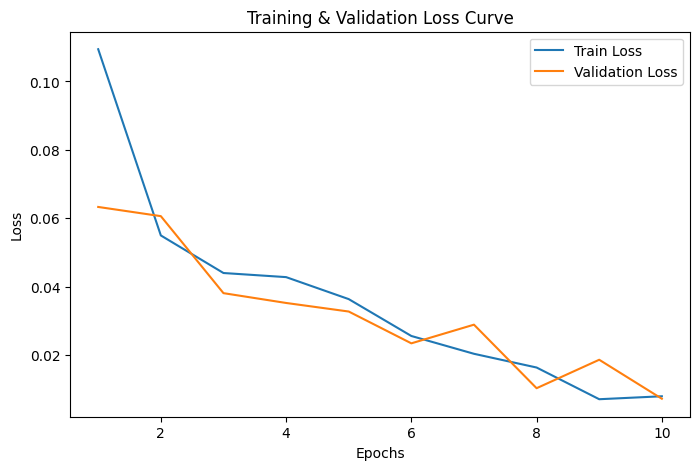

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
def train(num_epochs = 10,milestones = [5], gamma = 0.5):
    """
    Train the model with ADAM gradient minimizer. 
    The learning rate is multiplied by the gamma value each time the epoch reaches a milestone.
    """
    # Create train and test datasets
    train_dataset, test_dataset = create_train_dataset(), create_test_dataset()

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model (ensure DrawLocatorNet takes two inputs)
    model = DrawLocatorNet().to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Coordinate regression loss
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    train_loss = []
    eval_loss = []

    model_name = f"e{num_epochs}_g{int(100*gamma)}.pth"
    # Open log file
    log_file = open("training_logs.txt", "w")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for batch_idx, (field_img, draw_img, labels) in enumerate(train_loader):
            # Move data to GPU if available
            field_img = field_img.to(device).float()
            draw_img = draw_img.to(device).float()
            labels = labels.to(device).float()  # Shape: (B,2)

            optimizer.zero_grad()
            outputs = model(field_img, draw_img)  # Model expects two inputs
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Log predictions and actual labels
            for i in range(len(labels)):
                log_file.write(f"Epoch: {epoch+1}, Batch: {batch_idx}, Train Prediction: {outputs[i].cpu().tolist()}, Actual: {labels[i].cpu().tolist()}\n")

        epoch_train_loss = running_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f}")

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (field_img, draw_img, labels) in enumerate(val_loader):
                field_img = field_img.to(device).float()
                draw_img = draw_img.to(device).float()
                labels = labels.to(device).float()

                outputs = model(field_img, draw_img)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                # Log validation predictions and actual labels
                for i in range(len(labels)):
                    log_file.write(f"Epoch: {epoch+1}, Batch: {batch_idx}, Val Prediction: {outputs[i].cpu().tolist()}, Actual: {labels[i].cpu().tolist()}\n")

        epoch_val_loss = running_val_loss / len(val_loader)
        eval_loss.append(epoch_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {epoch_val_loss:.4f}")
        print(f"Average pixels error: {np.sqrt(epoch_val_loss)*210} pixels")
        # Flush log file to ensure data is written
        log_file.flush()
        scheduler.step()  # Update learning rate
        os.makedirs("models", exist_ok=True)  # Create the folder if it doesn't exist
        torch.save(model.state_dict(), f"models/e{num_epochs}_g{int(100*gamma)}_{epoch}.pth")
    # Close log file
    log_file.close()
    #Create folder
    save_dir = "final_models"  # Change this to your desired subfolder name
    os.makedirs(save_dir, exist_ok=True)  # Create the folder if it doesn't exist
    # Save the trained model
    torch.save(model.state_dict(),"final_models/"+ model_name)
    print(f"Model {model_name} saved ! ")
    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_loss, label="Train Loss")
    plt.plot(range(1, num_epochs+1), eval_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss Curve")

    save_path = os.path.join(save_dir, f"Loss {model_name[:-4]}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


train(num_epochs=10,milestones=[5],gamma=0.5)
